In [1]:
# !pip install rasterio

# Reading satellite data rasterio

In [22]:
import rasterio as rio
from rasterio import plot
import fiona
import rasterio.mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import georaster
import geopandas as gpd
import glob
import numpy as np
from osgeo import gdal
import scipy.misc as sm
from PIL import Image
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [26]:

# #use fiona to open our AOI GeoJSON
# with fiona.open('C:/Users/Jeannette/Downloads/moza.geojson') as f:
#     map5 = [feature["geometry"] for feature in f]
#     print(map5)

In [4]:
image_path='C:/Users/Jeannette/Downloads/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE/GRANULE/L2A_T30UXB_A010316_20190226T111048/IMG_DATA/R10m/'

In [5]:
b4 = rio.open(image_path+'T30UXB_20190226T111049_B04_10m.jp2',driver = 'JP2OpenJPEG')#red
b3 = rio.open(image_path+'T30UXB_20190226T111049_B03_10m.jp2',driver = 'JP2OpenJPEG')#green
b2 = rio.open(image_path+'T30UXB_20190226T111049_B02_10m.jp2',driver = 'JP2OpenJPEG')#blue
b8 = rio.open(image_path+'T30UXB_20190226T111049_B08_10m.jp2',driver = 'JP2OpenJPEG')#nir

# Extraction metadata information from satellite image

In [6]:
print(b4.bounds)#Minimum bounding box in projected units

BoundingBox(left=600000.0, bottom=5590200.0, right=709800.0, top=5700000.0)


In [7]:
#get dimensions, in map units
widith_in_projected_units = b4.bounds.right - b4.bounds.left
height_in_projected_units = b4.bounds.top - b4.bounds.bottom

print("Width: {}, Height: {}".format(widith_in_projected_units, height_in_projected_units))


Width: 109800.0, Height: 109800.0


In [8]:
print(b4.count,b3.count,b2.count)# how many bands

1 1 1


In [9]:
b4.height# number of rows

10980

In [10]:
b4.width # number of columns

10980

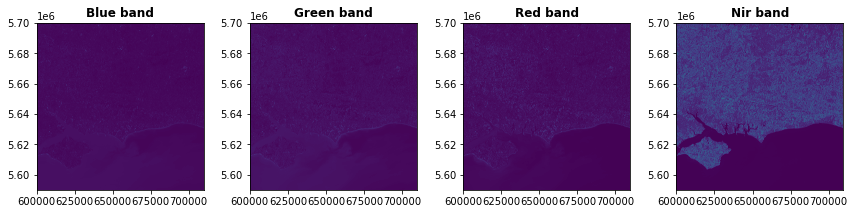

In [11]:
#plotting all bands separately
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(12,4))
plot.show(b2, ax = ax1, title='Blue band')
plot.show(b3, ax = ax2, title='Green band')
plot.show(b4, ax = ax3, title='Red band')
plot.show(b8, ax = ax4, title='Nir band')
fig.tight_layout()

In [12]:
b4.dtypes

('uint16',)

In [13]:
b4.crs# get coordinate reference sysytem

CRS.from_epsg(32630)

In [14]:
# dimensions of single pixel in meters
xres = (b4.bounds.right-b4.bounds.left)/b4.width
yres = (b4.bounds.top-b4.bounds.bottom)/b4.height
print(xres,yres)
print("are the pixels square: {}".format(xres==yres))

10.0 10.0
are the pixels square: True


In [15]:
#convert pixel coordinates to world coordinates.
#upper left pixel
row_min = 0
col_min = 0
# low right pixel. rows and columns are zero indexing
row_max = b4.height - 1
col_max = b4.width - 1
 #transform of coordinates with the data set's affine transformation
topleft = b4.transform * (row_min,col_min)
botright = b4.transform * (row_max,col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (600000.0, 5700000.0)
Bottom right corner coordinates: (709790.0, 5590210.0)


In [16]:
b4.profile

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5700000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}

In [17]:
b4.read(1)

array([[788, 312, 166, ..., 395, 452, 254],
       [376, 174, 159, ..., 696, 468, 313],
       [425, 183, 134, ..., 933, 636, 526],
       ...,
       [260, 261, 258, ...,  63,  66,  64],
       [274, 261, 265, ...,  65,  60,  53],
       [258, 261, 268, ...,  54,  52,  58]], dtype=uint16)

# RGB image

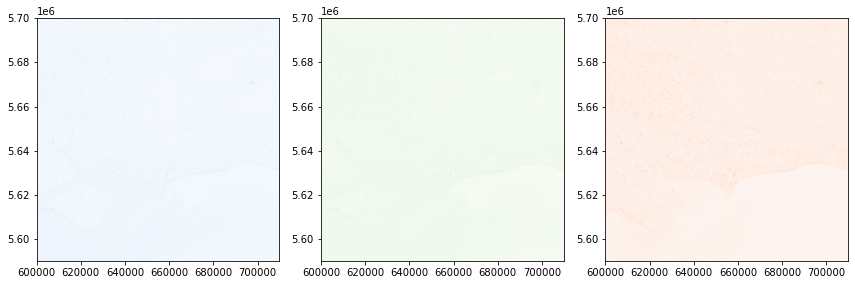

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
plot.show(b2, ax = ax1, cmap='Blues')
plot.show(b3, ax = ax2, cmap='Greens')
plot.show(b4, ax = ax3, cmap='Reds')
fig.tight_layout()

In [19]:
truecolor = rio.open('C:/Users/Jeannette/Downloads/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE/GRANULE/L2A_T30UXB_A010316_20190226T111048/IMG_DATA/R10m/sentineltruecolor.tiff','w',driver='Gtiff',
                     width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]
                    )
truecolor.write(b2.read(1),3) 
truecolor.write(b3.read(1),2) 
truecolor.write(b4.read(1),1) 
truecolor.close()

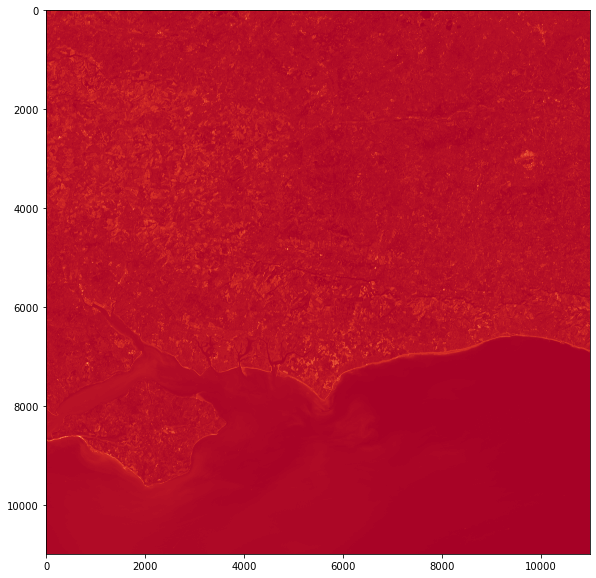

In [23]:
imgg = georaster.SingleBandRaster('C:/Users/Jeannette/Downloads/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE/GRANULE/L2A_T30UXB_A010316_20190226T111048/IMG_DATA/R10m/sentineltruecolor.tiff')

plt.figure(figsize = (10,10))
plt.imshow(imgg.r,cmap='RdYlGn')  

# NDVI Creation

In [ ]:
############################################

In [ ]:
# Function of NDVI

In [24]:
red = rio.open(image_path+'T30UXB_20190226T111049_B04_10m.jp2',driver = 'JP2OpenJPEG')#red
nir = rio.open(image_path+'T30UXB_20190226T111049_B08_10m.jp2',driver = 'JP2OpenJPEG')#nir
def ndvi(red,nir):
    return (nir-red)/(nir+red)

# Open each band using gdal
red_link = gdal.Open(image_path+'T30UXB_20190226T111049_B04_10m.jp2')
nir_link = gdal.Open(image_path+'T30UXB_20190226T111049_B08_10m.jp2')

# read in each band as array and convert to float for calculations
red = red_link.ReadAsArray().astype(np.float)
nir = nir_link.ReadAsArray().astype(np.float)

# Call the ndvi() function on red, NIR bands
ndvi2 = ndvi(red, nir)
 
# Create output filename based on input name 
outfile_name =  'NDVISs.tif'
 
x_pixels = ndvi2.shape[0] # number of pixels in x
y_pixels = ndvi2.shape[1] # number of pixels in y
 
# Set up output GeoTIFF
driver = gdal.GetDriverByName('GTiff')
 
# Create driver using output filename, x and y pixels, # of bands, and datatype
ndvi_data = driver.Create(outfile_name,x_pixels, y_pixels, 1,gdal.GDT_Float32)
 
# Set NDVI array as the 1 output raster band
ndvi_data.GetRasterBand(1).WriteArray(ndvi2)
 
# Setting up the coordinate reference system of the output GeoTIFF
geotrans=red_link.GetGeoTransform() # Grab input GeoTranform information
proj=red_link.GetProjection() # Grab projection information from input file
 
# now set GeoTransform parameters and projection on the output file
ndvi_data.SetGeoTransform(geotrans) 
ndvi_data.SetProjection(proj)
ndvi_data.FlushCache()
ndvi_data=None


Text(0.5, 1.0, 'Sentinel2A - Normalized Difference Vegetation Index (NDVI)')

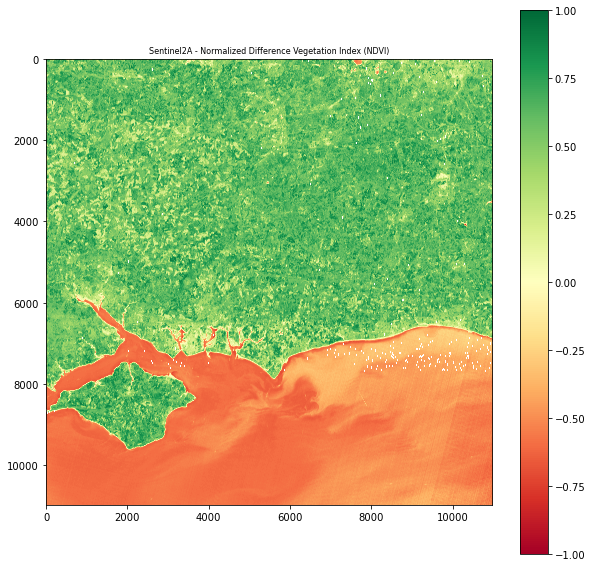

In [108]:
img = georaster.SingleBandRaster('C:/Users/Jeannette/Downloads/NDVISs.tif')

plt.figure(figsize = (10,10))
plt.imshow(img.r,cmap='RdYlGn')
plt.colorbar()
plt.title("Sentinel2A - Normalized Difference Vegetation Index (NDVI)",fontsize=8) 


In [ ]:
########################################
####################################
#####################################

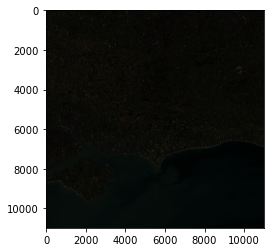

In [25]:
#RGB function


# Set input directory
in_dir ='C:/Users/Jeannette/Downloads/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349/S2B_MSIL2A_20190226T111049_N0211_R137_T30UXB_20190226T172349.SAFE/GRANULE/L2A_T30UXB_A010316_20190226T111048/IMG_DATA/R10m/'

# Search directory for desired bands
b4_file = glob.glob(in_dir +'T30UXB_20190226T111049_B04_10m.jp2')#red
b3_file = glob.glob(in_dir +'T30UXB_20190226T111049_B03_10m.jp2')#green
b2_file = glob.glob(in_dir +'T30UXB_20190226T111049_B02_10m.jp2')#blue


# Define a function to normalize each band array by the min and max values
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

# Loop through however many Landsat 8 obs are in the input directory 
for i in range(len(b2_file)):   
    
    # Open each band using gdal
    b2_link = gdal.Open(b2_file[i])
    b3_link = gdal.Open(b3_file[i])
    b4_link = gdal.Open(b4_file[i])
    
    # call the norm function on each band as array converted to float
    b2 = norm(b2_link.ReadAsArray().astype(np.float))
    b3 = norm(b3_link.ReadAsArray().astype(np.float))
    b4 = norm(b4_link.ReadAsArray().astype(np.float))
    
    # Create RGB
    rgb = np.dstack((b4,b3,b2))
    del b2, b3, b4
    
    #Visualize RGB
    import matplotlib.pyplot as plt
    plt.imshow(rgb,cmap='RdYlGn')
  